In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader,Subset
import torchvision
import os
import cv2 as cv
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

### custom dataset class

In [3]:
classes=["COVID","Lung_Opacity","Normal","Viral_Pneumonia"]

class XrayImagesDataset(Dataset):
  def __init__(self,data_dir,classes,transform):
    
    self.data_dir=data_dir
    self.transform=transform
    self.classes=classes
    self.data=[]
    
    for c in self.classes:
      for img in os.listdir(self.data_dir+"/"+c+"/images/"):
        self.data.append({"path":img,"class":c})
  
  def __len__(self):
    return len(self.data)
    
  def __getitem__(self,index):
    
    img_class=self.data[index]["class"]
    img_name=self.data[index]["path"]
    path=self.data_dir+"/"+img_class+"/images/"+img_name
    
    image =  Image.open(path).convert('RGB')
        
    return self.transform(image),classes.index(self.data[index]["class"])

In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
])
data=XrayImagesDataset("dataset/COVID-19_Radiography_Dataset",classes,transform)

### data splitting into train val and test then loading it in the dataloader

In [5]:
#so i tried this the other way by splitting the custom dataset class
#then loading train valid test seperately but SPLITTING TOOK AGES
#so i used this method i found online it splits data indices instead of
#the data itself then uses the pytorch Subset class for each split and loads 
indices = list(range(data.__len__()))

train_indices, valid_and_test_indices = train_test_split(indices, test_size=0.2, random_state=42)

valid_indices, test_indices = train_test_split(valid_and_test_indices, test_size=0.5, random_state=42)

train_subset = Subset(data, train_indices)
valid_subset = Subset(data, valid_indices)
test_subset = Subset(data, test_indices)

batch_size=10

train_dataloader = DataLoader(train_subset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_subset, batch_size=batch_size)

### some visualisation

In [6]:
#get a batch of the first 100 images
images, labels = next(iter(train_dataloader))

In [7]:
images[0].shape

torch.Size([3, 224, 224])

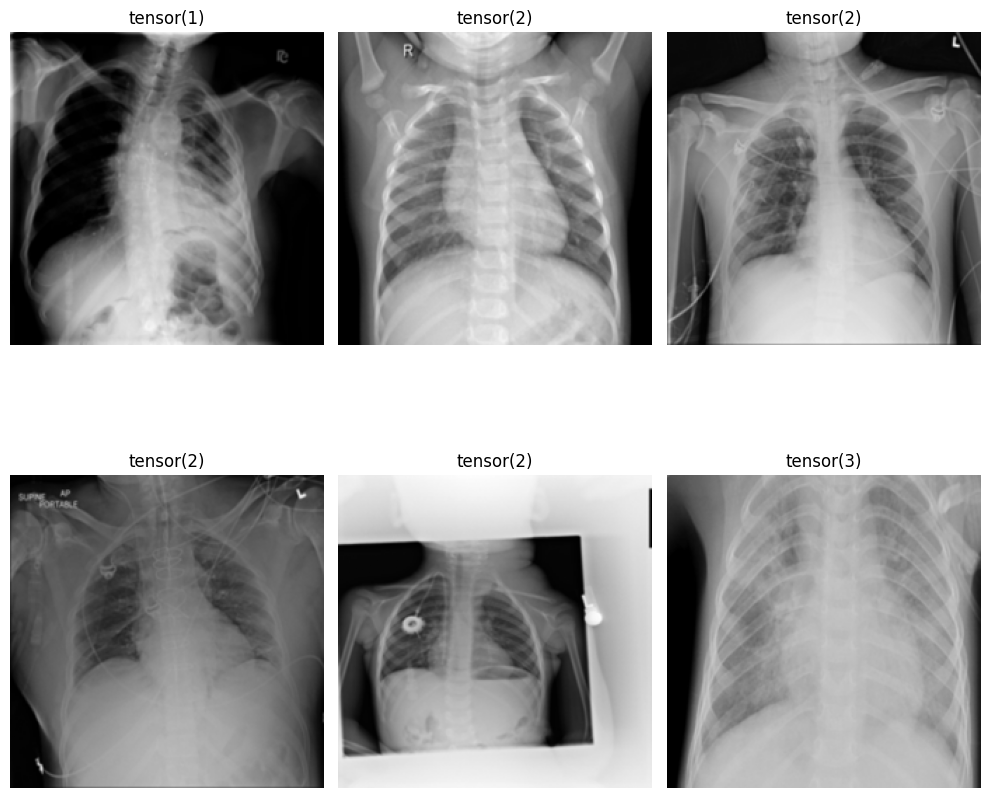

In [8]:
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    #transpose because pillow wants to act all different and cool
    image = images[i].numpy().transpose((1, 2, 0))
    plt.title(labels[i])
    plt.axis('off')
    plt.imshow(np.asarray(image))
plt.tight_layout()
plt.show()

### fine tuning some models you know the drill

In [9]:
resnet50 = torchvision.models.resnet50(pretrained=True)
mobilenetv3=torchvision.models.mobilenet_v3_large(pretrained=True)

d:\dev stuff\vgg16-test\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\dev stuff\vgg16-test\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\dev stuff\vgg16-test\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weig

In [10]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#finetuning 
resnet50.fc = torch.nn.Linear(in_features=2048, out_features=4)

#transferlearning
# for param in model_conv.parameters():
#     param.requires_grad = False
# for param in resnet50.fc.parameters():
#     param.requires_grad = True
# optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=0.00001)
loss_fn = torch.nn.CrossEntropyLoss()
#to change the learning rate
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.00001)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs, labels = images.to(device), labels.to(device)

In [13]:
#i'll do this on my gpu may god have mercy on your soul if you're doing it on cpu 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)
# images=torch.tensor(images).to(device)
# labels=torch.tensor(labels).to(torch.device(device))

In [ ]:
def train(model,epochs):
    print('TRAINING')
    epochs=1
    for e in range(0, epochs):
        print('-'*30)
        print(e + 1,'/',epochs,"epochs")
        print('-'*30)

        train_loss = 0.
        val_loss = 0.

        model.train() #set model to training phase

        for train_step, (images, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                
                print("step: ", train_step,"/",len(train_dataloader))
                accuracy = 0
                #set model to eval
                model.eval()
                
                for val_step, (images, labels) in enumerate(valid_dataloader):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).cpu().numpy())
                    
                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_subset)
                print("val_loss: ",val_loss," accuracy: ",accuracy)

                #set model to train mode again
                model.train()

        train_loss /= (train_step + 1)
        print("train loss:", train_loss)
    print('Training complete..')

In [17]:
train(resnet50,1)

TRAINING
------------------------------
1 / 1 epochs
------------------------------
step:  0 / 1694
val_loss:  1.6227209562400602  accuracy:  0.16910722720831364
step:  20 / 1694
val_loss:  1.3219421489032277  accuracy:  0.3689182805857345
step:  40 / 1694
val_loss:  1.1529290670414167  accuracy:  0.651393481341521
step:  60 / 1694
val_loss:  1.0435328818127885  accuracy:  0.7241379310344828
step:  80 / 1694
val_loss:  0.8774943201500502  accuracy:  0.7335852621634388
step:  100 / 1694
val_loss:  0.7463493957969183  accuracy:  0.7553141237600378
step:  120 / 1694
val_loss:  0.6776444218981813  accuracy:  0.7888521492678319
step:  140 / 1694
val_loss:  0.6473261731799427  accuracy:  0.8016060462919226
step:  160 / 1694
val_loss:  0.5892170402041846  accuracy:  0.8323098724610297
step:  180 / 1694
val_loss:  0.545729018130501  accuracy:  0.8445914029286726
step:  200 / 1694
val_loss:  0.5059118943857256  accuracy:  0.8649031648559282
step:  220 / 1694
val_loss:  0.46670365801090297  accu

### plotting some tests

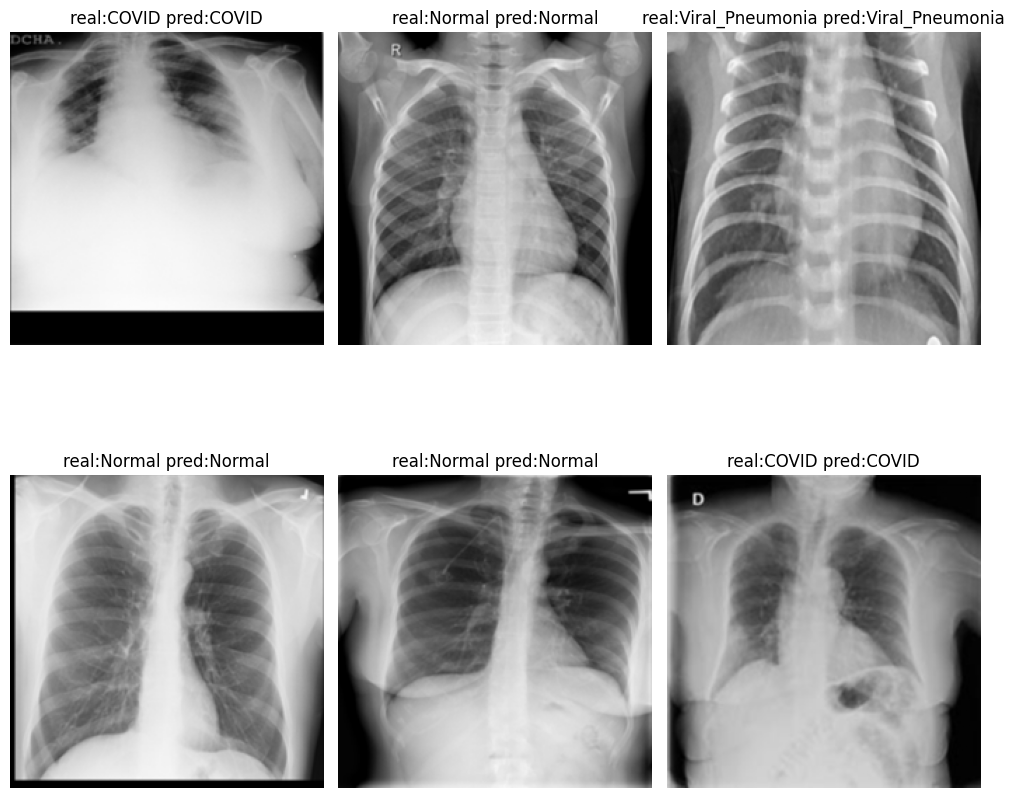

In [54]:
resnet50.eval()
images, labels = next(iter(test_dataloader))
images, labels =images.to(device), labels.to(device)
outputs = resnet50(images)
_, preds = torch.max(outputs, 1)
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(2, 3, i + 1) 
    #transpose because pillow wants to act all special and different from opencv and stuff whatever man
    image = images[i].cpu().numpy().transpose((1, 2, 0))
    plt.title("real:"+str(classes[int(labels[i])])+" pred:"+str(classes[int(preds[i])]))
    plt.axis('off')
    plt.imshow(image)
plt.tight_layout()
plt.show()

### saving the model

In [22]:
torch.save(resnet50.state_dict(),"resnet50.pth")